In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt

In [3]:
# import modules from 2p-py
import labrotation.file_handling as file_handling
import labrotation.two_photon_session as two_photon_session
import labrotation.belt_processing as belt_processing

In [4]:
matlab_2p_path = file_handling.open_dir("Choose matlab-2p folder!")

In [5]:
nd2_path = file_handling.open_file("Choose Nikon imaging file (.nd2)!")
nd2_meta_path = file_handling.open_file("Choose Nikon metadata file (.txt)!")
labview_path = file_handling.open_file("Choose LabView file (xy.txt, NOT xytime.txt)!")
labview_timestamps_path = labview_path[:-4] + "time.txt"
lfp_path = file_handling.open_file("Choose LFP file (.abf)!")

In [6]:
session = two_photon_session.TwoPhotonSession(nd2_path, nd2_meta_path, labview_path, labview_timestamps_path, lfp_path, matlab_2p_path)

D:\Software\Anaconda\envs\py9\lib\site-packages\pims\base_frames.py:472: UserWarning: Please call FramesSequenceND.__init__() at the start of thethe reader initialization.
  warn("Please call FramesSequenceND.__init__() at the start of the"
D:\PhD\2p-py\labrotation\two_photon_session.py:214: UserWarning: Warning! more than 30 s difference detected between starting the LFP and the Nikon recording!
Possible cause: bug in conversion to utc (daylight saving mode, timezone conversion).
lfp: 2021-06-27 10:05:53.191000+00:00
nikon: 2021-06-27 10:06:49.552985+00:00
offset (s): 56.361985
  warnings.warn(


Difference of starting times (s): 56.361985


In [13]:
# for T333 d2: 7.540202 - 7.573002
# for NC: idk
session.shift_lfp(, match_type="zero")  # use shift_lfp() to correct matching issues

In [8]:
def plotWindowCompareMax(t_min, t_max):
    """
    v2. Use this function to zoom in at bursts of movements, compare the max values 
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 18))

    # LFP first
    lfp_mov_t, lfp_mov_v = session.lfp_movement()
    # limit data to window
    lfp_mov_t_win = lfp_mov_t[(lfp_mov_t >= t_min) & (lfp_mov_t <= t_max)]
    lfp_mov_v_win = lfp_mov_v[lfp_mov_t_win.index]

    # find maximum of lfp data in window
    t_lfp_max = lfp_mov_t_win[lfp_mov_v_win.idxmax()]


    # LabView second
    lv_mov_t, lv_mov_v = session.labview_movement()

    lv_mov_t_win = lv_mov_t[(lv_mov_t >= t_min) & (lv_mov_t <= t_max)]
    lv_mov_v_win = lv_mov_v[lv_mov_t_win.index]

    t_lv_max = lv_mov_t_win[lv_mov_v_win.idxmax()]
    ax1.plot(lfp_mov_t_win, lfp_mov_v_win)
    ax1.axvline(t_lfp_max, color="r")
    ax2.plot(lv_mov_t_win, lv_mov_v_win)
    ax2.axvline(t_lv_max, color="r")
    ax2.set_xlim([t_min, t_max])

    print(f"LFP max: { t_lfp_max }\nLV  max: {t_lv_max }\nAdd {t_lv_max - t_lfp_max} to LFP")
    plt.show()

LFP max: 96.40617296510342
LV  max: 96.40475100000002
Add -0.001421965103403977 to LFP


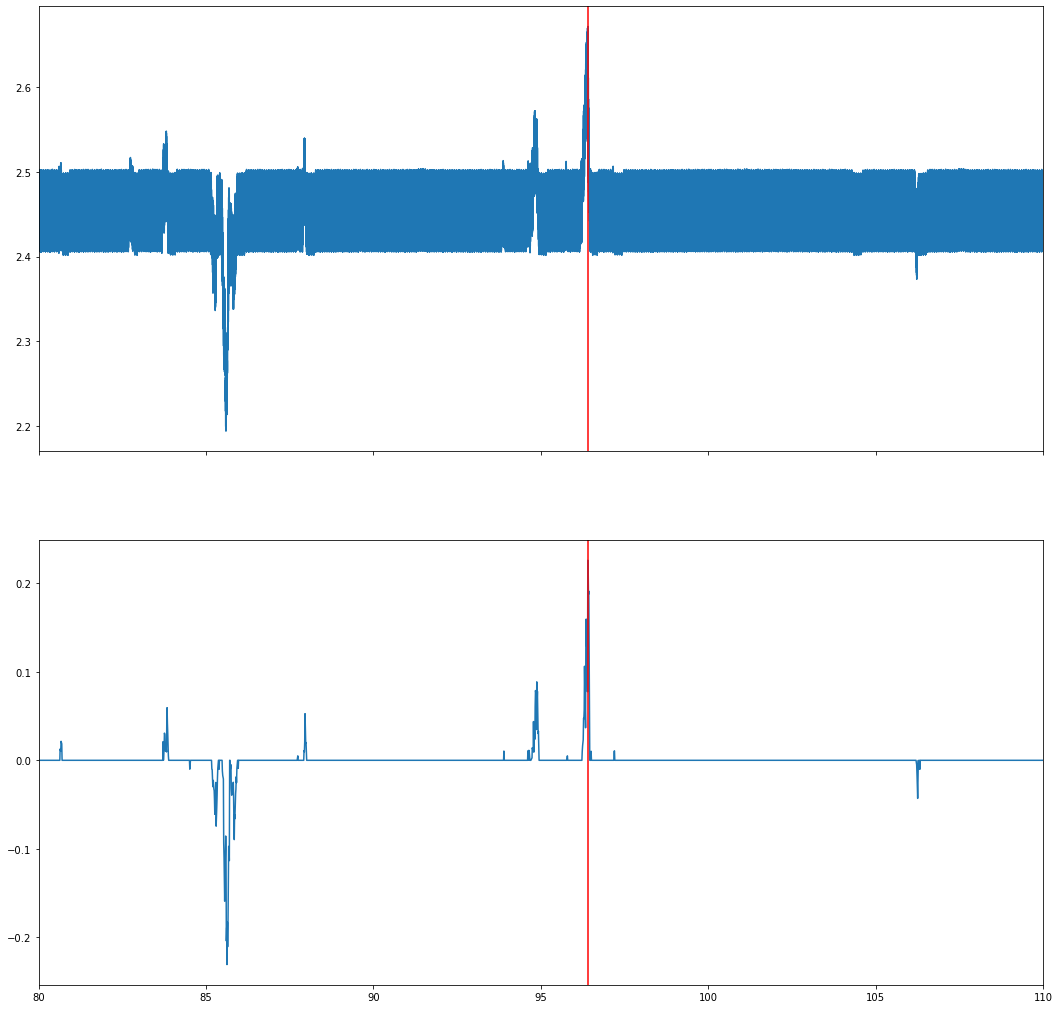

In [16]:
#plotWindowCompareMax(770, 790)  # for T333 d2
plotWindowCompareMax(80, 110) 

In [17]:
#Nikon indices
# for T333 d2:
#frame_begin = 10050
#frame_end = 12700
# for nC:
frame_begin = 0
frame_end = 1094

In [18]:
lfp =  session.lfp_lfp()
mov = session.lfp_movement()
nik_t = session.nikon_daq_time
nik_mean = session.return_nikon_mean()
nik_movie = session.get_nikon_data(frame_begin, frame_end)

In [19]:
#LabView indices
t_0 = nik_t[frame_begin]
t_1 = nik_t[frame_end]

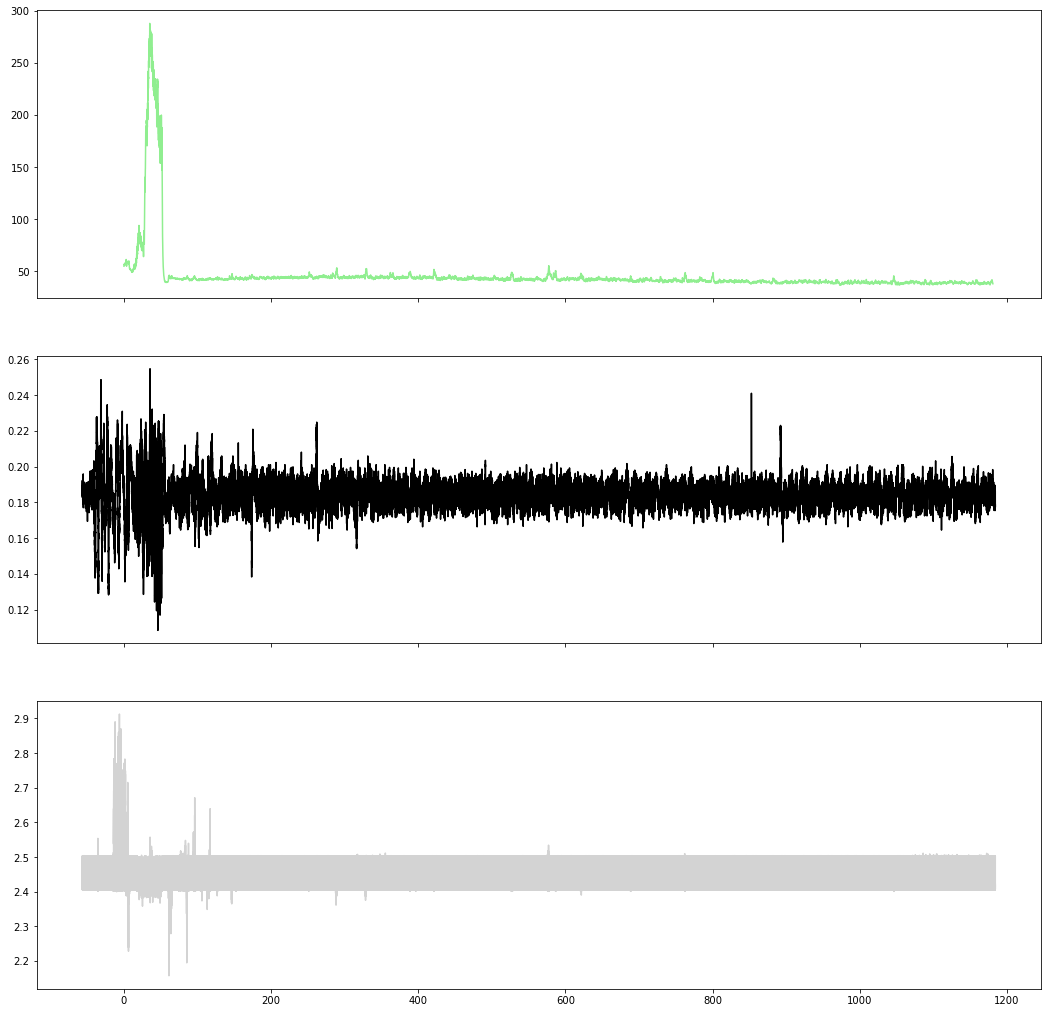

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(18,18), sharex = True)
ax[0].plot(nik_t, nik_mean, color="lightgreen")
ax[1].plot(*lfp, color="black")
ax[2].plot(*mov, color="lightgrey")
plt.show()

In [21]:
import matplotlib
FONT_SIZE = 20
matplotlib.rc('font', size=FONT_SIZE)
matplotlib.rc('axes', titlesize=FONT_SIZE)

In [22]:
def plotFrame(i_frame):  # i_frame should run from frame_begin to frame_end (inclusive)
    fig = plt.figure(figsize=(18,10))
    ax1 = plt.subplot2grid((3, 5), (0, 0), colspan=2)  # Nikon frame mean
    ax2 = plt.subplot2grid((3, 5), (1, 0), colspan=2)  # LFP
    ax3 = plt.subplot2grid((3, 5), (2, 0), colspan=2)  # movement
    ax4 = plt.subplot2grid((3, 5), (0, 2), colspan=3, rowspan = 3)  # Nikon video frame
    
    ax1.plot(nik_t, nik_mean, color="lightgreen")
    ax1.axvline(nik_t[frame_begin + i_frame], color="r")
    ax2.plot(*lfp, color="black")
    ax2.axvline(nik_t[frame_begin + i_frame], color="r")
    ax3.plot(*mov, color="lightgrey")
    ax3.axvline(nik_t[frame_begin + i_frame], color="r")
    
    
    ax4.pcolor(nik_movie[i_frame], cmap='gray')
    ax4.set_aspect('equal')
    ax4.invert_yaxis()  # for pcolor, need to flip y so that (0, 0) is top left, not bottom left.
    ax4.axis('off')
    
    ax1.set_xlim((t_0, t_1))
    ax2.set_xlim((t_0, t_1))
    ax3.set_xlim((t_0, t_1))
    
    ax1.set_ylabel("Avg. intensity (a.u.)")
    ax2.set_ylabel("LFP (a.u.)")
    ax3.set_ylabel("Velocity (a.u.)")
    ax3.set_xlabel("time in recording (s)", size=22)
    
    
    plt.tight_layout()
    print(i_frame)

200


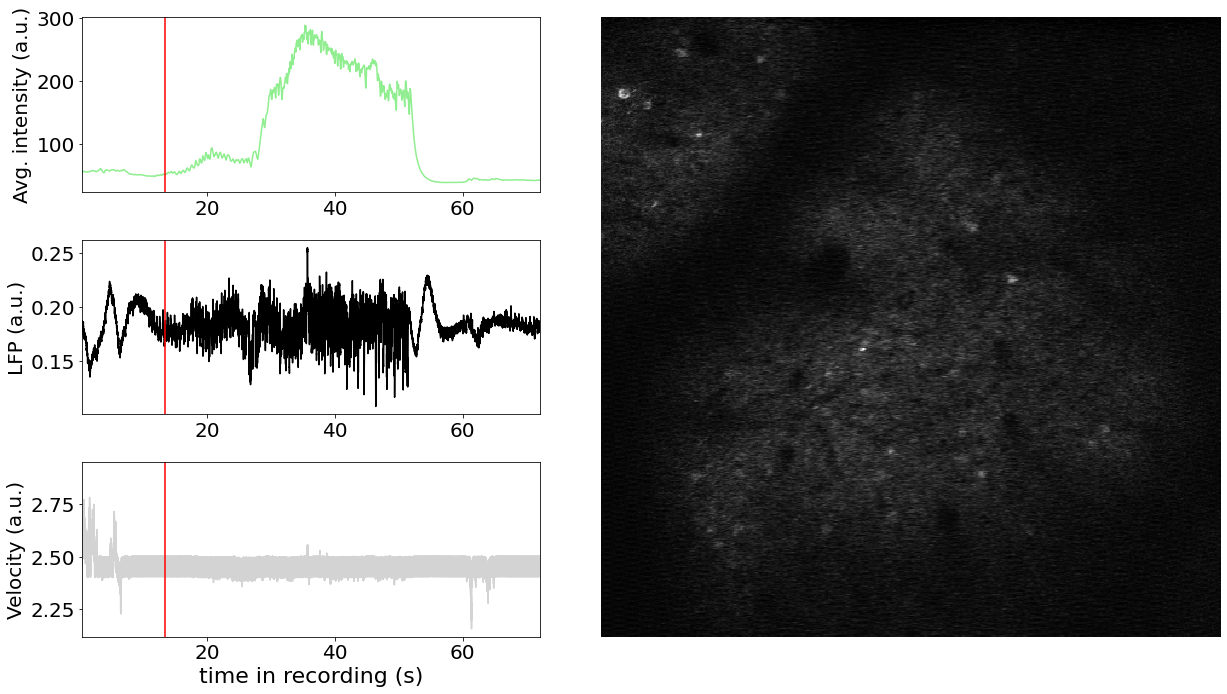

In [23]:
plotFrame(200)

# Try plotly

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
fig = px.imshow(nik_movie[0], color_continuous_scale='gray')
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

In [ ]:
fig = px.imshow(nik_movie[0], color_continuous_scale='gray')
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show()

# Matplotlib animate

In [24]:
import matplotlib.animation as animation
import numpy as np

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

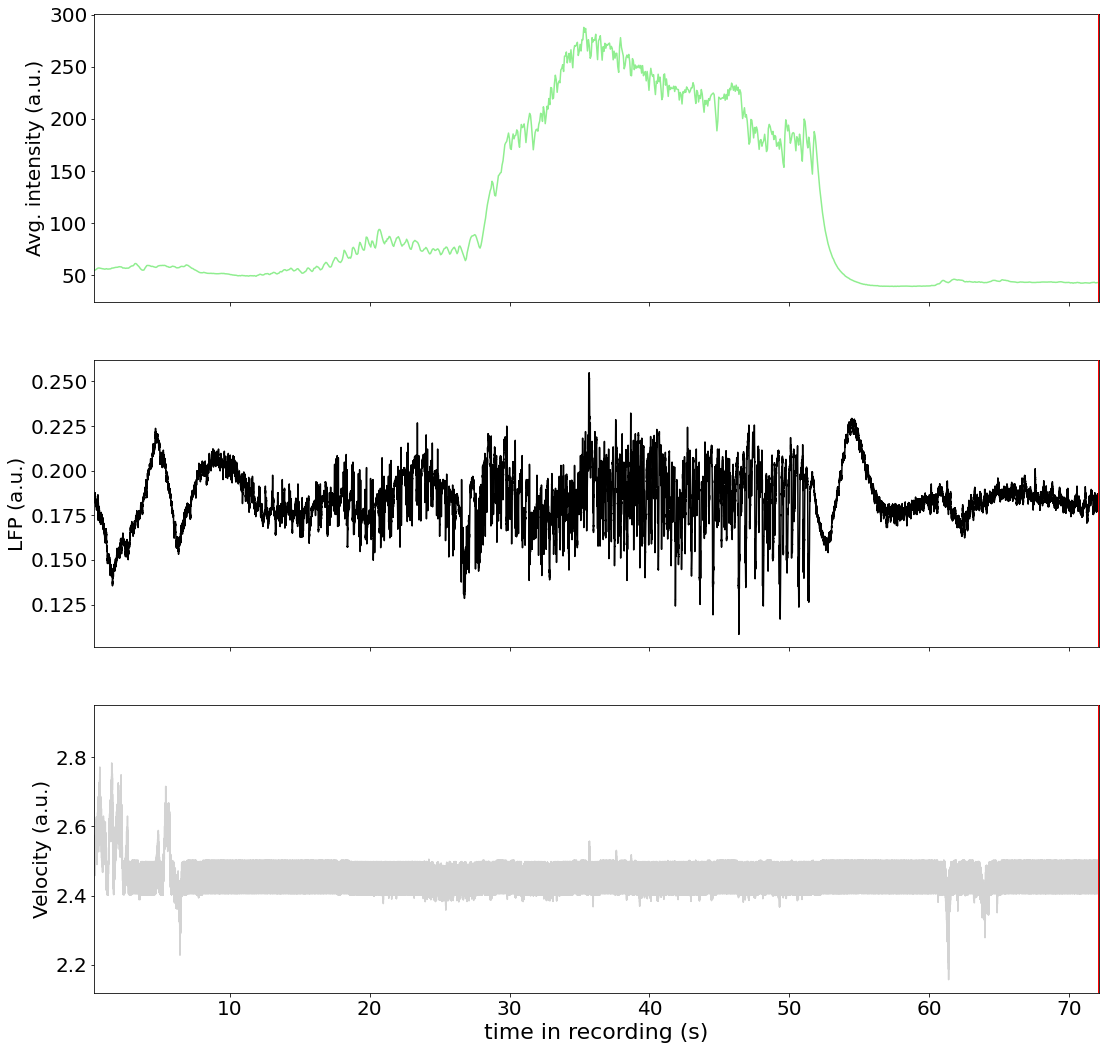

In [25]:
fig,axs = plt.subplots(3, figsize=(18, 18), sharex=True)


axs[0].plot(nik_t, nik_mean, color="lightgreen")
axs[1].plot(*lfp, color="black")
axs[2].plot(*mov, color="lightgrey")

axs[0].set_ylabel("Avg. intensity (a.u.)")
axs[1].set_ylabel("LFP (a.u.)")
axs[2].set_ylabel("Velocity (a.u.)")
axs[2].set_xlabel("time in recording (s)", size=22)


vl0 = axs[0].axvline(0, ls='-', color='r', lw=1, zorder=10)
vl1 = axs[1].axvline(0, ls='-', color='r', lw=1, zorder=10)
vl2 = axs[2].axvline(0, ls='-', color='r', lw=1, zorder=10)


for i_subplot in range(len(axs)):
    axs[i_subplot].set_xlim(nik_t[frame_begin], nik_t[frame_end])


def animate(i):
    print(i)
    vl0.set_xdata([nik_t[frame_begin + i],nik_t[frame_begin + i]])
    vl1.set_xdata([nik_t[frame_begin + i],nik_t[frame_begin + i]])
    vl2.set_xdata([nik_t[frame_begin + i],nik_t[frame_begin + i]])
    return vl0, vl1, vl2

def init():
    vl0.set_xdata([nik_t[frame_begin],nik_t[frame_begin]])
    vl1.set_xdata([nik_t[frame_begin],nik_t[frame_begin]])
    vl2.set_xdata([nik_t[frame_begin],nik_t[frame_begin]])
    return vl0, vl1, vl2

ani = animation.FuncAnimation(fig, animate, frames=frame_end - frame_begin, init_func = init, interval=66.6667, blit=True)
ani.save("testmov2.avi")